In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas_ta as ta
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import warnings
import quantstats as qs
warnings.filterwarnings("ignore")


In [31]:
bist100=pd.read_excel("./excel/bist100.xlsx")
bist100=bist100["Kod"].values
for i in range(len(bist100)):
    bist100[i]=bist100[i]+".IS"

In [32]:
son=pd.read_excel("./excel/FiyatPenceresi.Xlsx")
son=son[["Kod","Son.Fyt","Hcm","Yks","Dşk"]]
son.columns=["Hisse","Adj Close","Volume","High","Low"]
son=son.iloc[:-1,:]
son=son.dropna()


In [33]:
hisseler=son["Hisse"].values
hisseler=np.array(hisseler)

In [34]:
for i in range(len(hisseler)):
    hisseler[i]=hisseler[i]+".IS"

In [35]:
df=pd.DataFrame()
for hisse in hisseler:
    hisse_verileri = yf.download(hisse,start="2010-01-01")  # Örnek tarih aralığı
    hisse_kapanis = hisse_verileri[['High','Low','Open','Close','Volume']]
    hisse_kapanis["Hisse"]=hisse
    hisse_kapanis.loc[hisse_kapanis["Close"] > hisse_kapanis["High"], "High"] = hisse_kapanis["Close"]
    hisse_kapanis.loc[hisse_kapanis["Close"] < hisse_kapanis["Low"], "Low"] = hisse_kapanis["Close"]

    df=pd.concat([df,hisse_kapanis],axis=0)
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,High,Low,Open,Close,Volume,Hisse
Date,,,,,,
2023-06-15,27.500000,27.500000,27.500000,27.500000,262214,A1CAP.IS
2023-06-16,30.240000,30.240000,30.240000,30.240000,1169499,A1CAP.IS
2023-06-20,31.100000,29.940001,31.000000,29.940001,8064437,A1CAP.IS
2023-06-21,26.959999,26.959999,26.959999,26.959999,2147415,A1CAP.IS
2023-06-22,27.620001,25.500000,25.620001,25.940001,71898180,A1CAP.IS
...,...,...,...,...,...,...
2024-06-05,8.070000,7.670000,7.970000,7.690000,2326506,ZRGYO.IS
2024-06-06,7.760000,7.530000,7.690000,7.540000,1654700,ZRGYO.IS
2024-06-07,8.080000,7.500000,7.600000,7.570000,13008816,ZRGYO.IS


In [36]:
ddata=df.copy()

In [37]:
df=ddata

In [38]:
df["Volume"]=df["Close"]*df["Volume"]

In [39]:
df["Close"]=np.round(df["Close"],2)
df["High"]=np.round(df["High"],2)
df["Low"]=np.round(df["Low"],2)
df["Open"]=np.round(df["Open"],2)

In [40]:
df.columns=['High', 'Low', 'Open', 'Adj Close', 'Volume', 'Hisse']

In [41]:
df["Kademe"] = np.where(df["Adj Close"] < 20, 0.01,
                np.where(df["Adj Close"] < 50, 0.02,
                    np.where(df["Adj Close"] < 100, 0.05,
                        np.where(df["Adj Close"] < 250, 0.1,
                            np.where(df["Adj Close"] < 500, 0.25,
                                np.where(df["Adj Close"] < 1000, 0.5,
                                    np.where(df["Adj Close"] < 2500, 1, 2.5)
                                )  # Buradaki parantez eksikti.
                            )
                        )
                    )
                )
            )


In [42]:
df["Tavan"]=((((df["Adj Close"].shift(1))*1.1)/df["Kademe"]).fillna(0).astype(int))*df["Kademe"]
df["Tavan"]=np.round(df["Tavan"],2)

In [43]:
df["Tavan Kontrol"]=np.where((df["Tavan"]==df["Adj Close"]),1,0)
df

,High,Low,Open,Adj Close,Volume,Hisse,Kademe,Tavan,Tavan Kontrol
Date,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0.02,0.00,0
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,0.02,30.24,1
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0.02,33.26,0
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0.02,32.92,0
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0.02,29.64,0
...,...,...,...,...,...,...,...,...,...
2024-06-05,8.07,7.67,7.97,7.69,1.789083e+07,ZRGYO.IS,0.01,8.74,0
2024-06-06,7.76,7.53,7.69,7.54,1.247644e+07,ZRGYO.IS,0.01,8.45,0
2024-06-07,8.08,7.50,7.60,7.57,9.847674e+07,ZRGYO.IS,0.01,8.29,0


In [44]:
df=df.drop(["Kademe","Tavan"],axis=1)

In [45]:
import pandas_ta as ta
df["RSI"]=ta.rsi(df["Adj Close"],14)
df["SMA 5"]=df["Adj Close"].rolling(5).mean()
df["SMA 10"]=df["Adj Close"].rolling(5).mean()
df["SMA 200"]=df["Adj Close"].rolling(5).mean()




df["Bağıl Hacim"] = df["Volume"] / df["Volume"].rolling(10).mean()



# ADX, DMI, Aroon
adx_data = ta.adx(df["High"], df["Low"], df["Adj Close"], 14)
df["ADX"], df["DMIP"], df["DMIN"] = adx_data.iloc[:, 0], adx_data.iloc[:, 1], adx_data.iloc[:, 2]




def calculate_stoch_rsi(data, rsi_period=14, stochastic_period=14, k_period=3, d_period=3):
    rsi = ta.rsi(data["Adj Close"], rsi_period)
    stoch_rsi = (rsi - rsi.rolling(window=stochastic_period).min()) / (rsi.rolling(window=stochastic_period).max() - rsi.rolling(window=stochastic_period).min())
    stoch_rsi_k = stoch_rsi.rolling(window=k_period).mean() * 100
    stoch_rsi_d = stoch_rsi_k.rolling(window=d_period).mean()
    data['StochRSI_%K'] = stoch_rsi_k
    data['StochRSI_%D'] = stoch_rsi_d
    return data

df = calculate_stoch_rsi(df)


def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    data['EMA_12'] = ta.ema(data['Adj Close'], short_period)
    data['EMA_26'] = ta.ema(data['Adj Close'], long_period)
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = ta.ema(data['MACD'], signal_period)
    data['MACD_above_Signal'] = (data['MACD'] > data['Signal_Line']).astype(float)
    return data

df = calculate_macd(df)



# Diğer Göstergeler
df["DD"] = ((df["Adj Close"] / df["High"]) - 1) * 100
df["Range"] = ((df["High"] - df["Low"]) / df["Adj Close"]) * 100

df["MOM"] = ta.mom(df["Adj Close"], 10)



df["Driehaus Momentum"] = ((df["Bağıl Hacim"] > 2) & (df["RSI"] > 50) & (df["MOM"] > 1) & (df["Adj Close"] > df["SMA 5"]) & (df["Adj Close"] > df["SMA 10"]) & (df["Adj Close"] > df["SMA 200"])).astype(int)
df["MACD Yukarı Kesen"] = ((df["Bağıl Hacim"] > 1.5) & (df["MACD"] > 0) & (df["MACD_above_Signal"] == 1)).astype(int)
df["ADXDMI20"] = ((df["Bağıl Hacim"] > 1.3) & (df["ADX"] > 20) & (df["DMIP"] > df["DMIN"])).astype(int)
df["MACD+Stoch"] = ((df["Bağıl Hacim"] > 1.3) & (df["StochRSI_%K"] > df["StochRSI_%D"]) & (df["MACD_above_Signal"] == 1)).astype(int)




In [46]:
# Hareketli Ortalamalar (SMA ve EMA)
import ta as ta



# MACD (Moving Average Convergence Divergence)
df['MACD'] = ta.trend.macd(df['Adj Close'])
df['MACD_Signal'] = ta.trend.macd_signal(df['Adj Close'])
df['MACD_Diff'] = ta.trend.macd_diff(df['Adj Close'])


# Göreceli Güç Endeksi (RSI)

# Stokastik Osilatör
df['Stoch_Oscillator'] = ta.momentum.stoch(df['High'], df['Low'], df['Adj Close'], window=14, smooth_window=3)

# Diğer göstergeler
df['ADX'] = ta.trend.adx(df['High'], df['Low'], df['Adj Close'], window=14)
df['CCI'] = ta.trend.cci(df['High'], df['Low'], df['Adj Close'], window=20)
df['ROC'] = ta.momentum.roc(df['Adj Close'], window=12)



In [47]:
df["Return"]=100*((df["Open"]/df["Adj Close"].shift(2))-1)
df["Return"]=df["Return"].shift(-2)

df["Gerçek Return"]=100*((df["Adj Close"]/df["Open"])-1)
df["Gerçek Return"]=df["Gerçek Return"].shift(-1)
df["Date"]=pd.to_datetime(df.index)
df


,High,Low,Open,Adj Close,Volume,Hisse,Tavan Kontrol,RSI,SMA 5,SMA 10,...,ADXDMI20,MACD+Stoch,MACD_Signal,MACD_Diff,Stoch_Oscillator,CCI,ROC,Return,Gerçek Return,Date
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,12.727273,0.000000,2023-06-15
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,1,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,-10.846561,-3.419355,2023-06-16
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,-14.428858,0.000000,2023-06-20
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,-3.041543,1.249024,2023-06-21
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0,NaN,28.116,28.116,...,0,0,NaN,NaN,NaN,NaN,NaN,-0.154202,-0.918133,2023-06-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,8.07,7.67,7.97,7.69,1.789083e+07,ZRGYO.IS,0,56.344675,7.930,7.930,...,0,0,0.195075,0.035199,48.148148,84.427904,0.918635,-1.170351,-1.950585,2024-06-05
2024-06-06,7.76,7.53,7.69,7.54,1.247644e+07,ZRGYO.IS,0,52.977055,7.860,7.860,...,0,0,0.197202,0.008509,37.037037,35.955797,-1.694915,1.458886,-0.394737,2024-06-06
2024-06-07,8.08,7.50,7.60,7.57,9.847674e+07,ZRGYO.IS,0,53.574695,7.742,7.742,...,1,0,0.195065,-0.008549,39.259259,53.487095,0.000000,-6.472919,-5.228758,2024-06-07


In [48]:
endeks1=yf.download(tickers="XU100.IS",end="2020-07-27")/100
endeks2=yf.download(tickers="XU100.IS",start="2020-07-27")
endeks=pd.concat([endeks1,endeks2],axis=0)
df["Endeks"]=endeks["Adj Close"]
df["Endeks Return"]=100*((df["Endeks"]/df["Endeks"].shift(1))-1)
df["Endeks Return Lag"]=100*((df["Endeks"].shift(1)/df["Endeks"].shift(2))-1)
df["Return Lag"]=((df["Adj Close"]/df["Adj Close"].shift(1))-1)*100
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,High,Low,Open,Adj Close,Volume,Hisse,Tavan Kontrol,RSI,SMA 5,SMA 10,...,Stoch_Oscillator,CCI,ROC,Return,Gerçek Return,Date,Endeks,Endeks Return,Endeks Return Lag,Return Lag
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,NaN,NaN,12.727273,0.000000,2023-06-15,5495.500000,NaN,NaN,NaN
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,1,NaN,NaN,NaN,...,NaN,NaN,NaN,-10.846561,-3.419355,2023-06-16,5475.500000,-0.363934,NaN,9.963636
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,NaN,NaN,-14.428858,0.000000,2023-06-20,5251.600098,-4.089122,-0.363934,-0.992063
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,NaN,NaN,-3.041543,1.249024,2023-06-21,5186.799805,-1.233915,-4.089122,-9.953240
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0,NaN,28.116,28.116,...,NaN,NaN,NaN,-0.154202,-0.918133,2023-06-22,5428.299805,4.656050,-1.233915,-3.783383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,8.07,7.67,7.97,7.69,1.789083e+07,ZRGYO.IS,0,56.344675,7.930,7.930,...,48.148148,84.427904,0.918635,-1.170351,-1.950585,2024-06-05,10351.000000,-0.131212,-1.820629,-3.270440
2024-06-06,7.76,7.53,7.69,7.54,1.247644e+07,ZRGYO.IS,0,52.977055,7.860,7.860,...,37.037037,35.955797,-1.694915,1.458886,-0.394737,2024-06-06,10279.700195,-0.688820,-0.131212,-1.950585
2024-06-07,8.08,7.50,7.60,7.57,9.847674e+07,ZRGYO.IS,0,53.574695,7.742,7.742,...,39.259259,53.487095,0.000000,-6.472919,-5.228758,2024-06-07,10139.000000,-1.368719,-0.688820,0.397878


In [49]:
df=df.dropna()

In [50]:
df=df.sort_index()

In [51]:
target_data = {
    "2024-02-13": "PATEK.IS",
    "2024-02-15": "BORSK.IS",
    "2024-02-22": "LMKDC.IS",
    "2024-02-29": "ALVES.IS",
    "2024-03-04": "ARTMS.IS",
    "2024-03-05": "MOGAN.IS",
    "2024-03-11": ["BARMA.IS", "INVES.IS", "EDATA.IS"],
    "2024-03-21": "ODINE.IS",
    "2024-04-26": "RGYAS.IS",
    "2024-05-02": ["OBAMS.IS", "ENTRA.IS"],
    "2024-05-09": "LILAK.IS",
    "2024-05-10": "KOTON.IS",
    "2024-05-16": "ALTNY.IS",
    "2024-05-17": "KOCMT.IS",
    "2024-05-23": "HRKET.IS",
    "2024-05-27": "PEHOL.IS",
    "2024-05-28": "ONRYT.IS",
    "2024-05-29": "OZYSR.IS",
    "2024-06-04": "ALKLC.IS",
    "2024-06-06": "YIGIT.IS",
    "2024-06-07": "HOROZ.IS"
}

In [52]:
for date, stocks in target_data.items():
    if isinstance(stocks, list):
        for stock in stocks:
            df.loc[(df.index == date) & (df["Hisse"] == stock), "Tavan Kontrol"] = 1
    else:
        df.loc[(df.index == date) & (df["Hisse"] == stocks), "Tavan Kontrol"] = 1

In [53]:
son=df.loc["2024-06-10":]
ilk=df.loc[:"2024-06-07"]
ilk=ilk[(ilk["Return"]<21) & (ilk["Return"]>-19)]
result=pd.concat([ilk,son],axis=0)

In [54]:


yasak=["YYAPI","EMNIS","TETMT","RODRG","BRKO","AYES","EUKYO","YGYO","BALAT","SONME","SNKRN","KSTUR","DERIM","UZERB","MARKA","MMCAS","YAYLA"]
for i in range(len(yasak)):
    yasak[i]=yasak[i]+".IS"

In [55]:

result = result[~result['Hisse'].isin(["ISATR.IS","ISBTR.IS"])]
result = result[~result['Hisse'].isin(yasak)]
result=result.sort_index()

In [56]:
result=result[result["Tavan Kontrol"]==0]

In [ ]:
import optuna
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit




def objective(trial):
    # Hyperparameter space
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30)
    }

    model = CatBoostRegressor(**param, verbose=0, random_seed=42, task_type="GPU")



    model.fit(X_train, y_train)

        
    tahminler=pd.DataFrame(val["Gerçek Return"])
    tahminler=tahminler.set_index(X_val.index)
    tahminler["Tahmin"]=model.predict(X_val)
    tahminler.columns=["Gerçek","Tahmin"]
    tahminler["Hisse"]=val["Hisse"]
    tahminler["Tavan"]=val["Tavan Kontrol"]
    tahminler=tahminler[tahminler["Tavan"]==0]


    top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(3, columns=['Tahmin'])).dropna()
    topkar = (top_5_rows.groupby('Date')["Gerçek"].mean().cumsum() )
    returns = (top_5_rows.groupby('Date')["Gerçek"].mean().cumsum()).diff().dropna()
    pozitif = returns[returns > 0].mean()
    negatif = returns[returns < 0].mean()
    ort = abs(pozitif / negatif)
    print(topkar.iloc[-1])
        

    
    return ort

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print('En iyi parametreler: ', study.best_params)
print('En iyi skor: ', study.best_value)


In [32]:
"""params ={'iterations': 363, 'depth': 9, 'learning_rate': 0.022966443559949937, 'random_strength': 13, 'bagging_temperature': 0.6758282260679829, 'border_count': 211, 'l2_leaf_reg': 18}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=123)
model.load_model("./model/bist100scaling.bin")"""

'params ={\'iterations\': 363, \'depth\': 9, \'learning_rate\': 0.022966443559949937, \'random_strength\': 13, \'bagging_temperature\': 0.6758282260679829, \'border_count\': 211, \'l2_leaf_reg\': 18}\nmodel=CatBoostRegressor(**params,task_type="GPU",random_seed=123)\nmodel.load_model("./model/bist100scaling.bin")'

In [33]:
"""params = {'iterations': 629, 'depth': 8, 'learning_rate': 0.03984954027131234, 'random_strength': 3, 'bagging_temperature': 0.39823126184519836, 'border_count': 229, 'l2_leaf_reg': 19}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=123)
model.load_model("./model/xtumykapanis.bin")"""

'params = {\'iterations\': 629, \'depth\': 8, \'learning_rate\': 0.03984954027131234, \'random_strength\': 3, \'bagging_temperature\': 0.39823126184519836, \'border_count\': 229, \'l2_leaf_reg\': 19}\nmodel=CatBoostRegressor(**params,task_type="GPU",random_seed=123)\nmodel.load_model("./model/xtumykapanis.bin")'

In [90]:
val=result.loc["2023-07-01":"2023-12-31"].dropna()
train=result.loc[:"2023-06-30"].dropna()
test=result.loc["2024-01-01":].dropna()
X_train=train[['Endeks Return','Return Lag','Range','RSI','Volume','Bağıl Hacim','DD','High', 'Low', 'Open', 'Adj Close','StochRSI_%K','MACD','ROC','MACD_Signal','MOM']]
X_test=test[['Endeks Return','Return Lag','Range','RSI','Volume','Bağıl Hacim','DD','High', 'Low', 'Open', 'Adj Close','StochRSI_%K','MACD','ROC','MACD_Signal','MOM']]
X_val=val[['Endeks Return','Return Lag','Range','RSI','Volume','Bağıl Hacim','DD','High', 'Low', 'Open', 'Adj Close','StochRSI_%K','MACD','ROC','MACD_Signal','MOM']]
y_train=train["Return"]
y_test=test["Return"]
y_val=val["Return"]

In [91]:
params = {'iterations': 406,
 'depth': 8,
 'learning_rate': 0.05908481614373525,
 'random_strength': 15,
 'bagging_temperature': 0.48897432777080385,
 'border_count': 163,
 'l2_leaf_reg': 9}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=42)
model.load_model("./model/xtumyson.bin")

In [104]:
tahminler=pd.DataFrame(test["Return"])
tahminler=tahminler.set_index(X_test.index)
tahminler["Tahmin"]=model.predict(X_test)
tahminler.columns=["Gerçek","Tahmin"]
tahminler["Hisse"]=test["Hisse"]
tahminler["Tavan"]=test["Tavan Kontrol"]
tahminler=tahminler[tahminler["Tavan"]==0]
tahminler=tahminler[tahminler["Tahmin"]>0.8]
top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(3, columns=['Tahmin'])).dropna()
topkar=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2)
returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).diff().dropna()
pozitif=returns[returns>0].mean()
negatif=returns[returns<0].mean()
ort=abs(pozitif/negatif)
ort

1.964871694063637

In [106]:
top_5_rows1=top_5_rows.copy()
top_5_rows2=top_5_rows.copy()
top_5_rows1["Gerçek"]-=0.08
top_5_rows2["Gerçek"]-=0.4

In [107]:
kar=(((np.cumprod(1+((top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2)/100)))-1)*100).iloc[-1]
returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2).diff().dropna()

sharpe=kar/returns.std()
sharpe

86.40381433323284

In [98]:
sharpes=[]
metrik=[]
adet=[]
karlar=[]
for i in range(1,30):
   top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(i, columns=['Tahmin'])).dropna()
   topkar=(((np.cumprod(1+((top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2)/100)))-1)*100).iloc[-1]
   returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2).diff().dropna()
   sharpe=topkar/returns.std()
   metrik.append(sharpe*topkar)
   sharpes.append(sharpe)
   adet.append(i)
   karlar.append(topkar)
sonuc=pd.DataFrame()
sonuc["Adet"]=adet
sonuc["Sharpe*Kar"]=metrik
sonuc["Sharpe"]=sharpes
sonuc["Kar"]=karlar
sonuc.sort_values(by="Kar",ascending=False)


,Adet,Sharpe*Kar,Sharpe,Kar
1,2,27794.336097,96.664661,287.533580
0,1,12030.665343,50.124202,240.017095
2,3,19362.177698,86.403814,224.089386
3,4,16530.534529,84.085334,196.592363
4,5,10520.407417,68.700393,153.134603
5,6,10570.204962,71.645632,147.534534
8,9,10524.686006,77.243308,136.253694
6,7,9498.002854,70.818001,134.118484
9,10,10518.662977,79.649545,132.061809
7,8,9121.496650,70.464269,129.448539


In [108]:
top_5_rows=top_5_rows.droplevel(level=0)
top_5_rows1=top_5_rows1.droplevel(level=0)
top_5_rows2=top_5_rows2.droplevel(level=0)

In [109]:
endeks=yf.download(tickers="XU100.IS",start="2023-07-01",end="2024-01-01")
endeks["Getiri"]=0
for i in range(len(endeks)):
    endeks["Getiri"].iloc[i]=100*((endeks["Adj Close"].iloc[i]/endeks["Adj Close"].iloc[0])-1)
endeks=endeks.fillna(0)
endeks

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Getiri
Date,,,,,,,
2023-07-03,5867.200195,6018.299805,5867.200195,6015.299805,6015.299805,3725885300,0.000000
2023-07-04,6049.700195,6076.700195,5980.100098,6003.899902,6003.899902,4768264400,-0.189515
2023-07-05,6026.100098,6121.600098,5889.899902,6106.799805,6106.799805,4054640000,1.521121
2023-07-06,6135.299805,6207.899902,6124.200195,6141.100098,6141.100098,4105306400,2.091339
2023-07-07,6139.799805,6223.299805,6117.100098,6187.100098,6187.100098,3663437400,2.856055
...,...,...,...,...,...,...,...
2023-12-22,7769.799805,7795.000000,7553.899902,7557.600098,7557.600098,1874128000,25.639625
2023-12-26,7303.299805,7405.100098,7202.899902,7299.299805,7299.299805,1937122200,21.345569
2023-12-27,7282.200195,7365.100098,7215.000000,7260.399902,7260.399902,2146187500,20.698887


In [110]:
endeks1=yf.download(tickers="XU100.IS",start="2024-01-01",end="2024-06-10")
endeks1["Getiri"]=0
for i in range(len(endeks1)):
    endeks1["Getiri"].iloc[i]=100*((endeks1["Adj Close"].iloc[i]/endeks1["Adj Close"].iloc[0])-1)
endeks1=endeks1.fillna(0)
endeks1

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Getiri
Date,,,,,,,
2024-01-02,7542.299805,7634.100098,7542.299805,7624.299805,7624.299805,2397081700,0.000000
2024-01-03,7624.600098,7624.600098,7411.799805,7412.000000,7412.000000,2169646100,-2.784515
2024-01-04,7421.899902,7547.799805,7387.000000,7547.799805,7547.799805,2391591200,-1.003371
2024-01-05,7570.100098,7628.700195,7532.200195,7628.700195,7628.700195,2355101900,0.057715
2024-01-08,7667.899902,7824.600098,7667.899902,7818.899902,7818.899902,2873781100,2.552367
...,...,...,...,...,...,...,...
2024-06-03,10443.200195,10564.900391,10334.799805,10556.799805,10556.799805,2819200600,38.462548
2024-06-04,10576.599609,10610.200195,10362.500000,10364.599609,10364.599609,2628421000,35.941659
2024-06-05,10403.200195,10434.700195,10239.599609,10351.000000,10351.000000,2695925200,35.763287


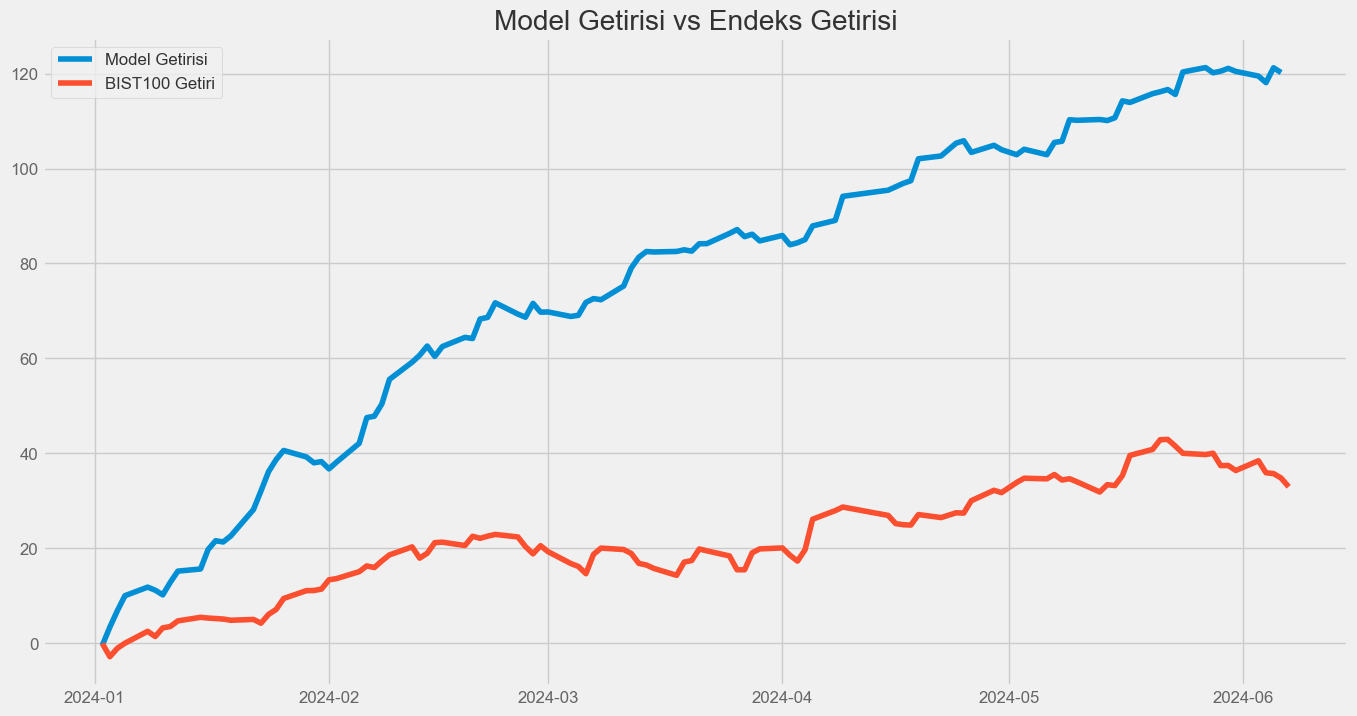

In [111]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.title("Model Getirisi vs Endeks Getirisi")
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Model Getirisi")
plt.plot(endeks1["Getiri"],label="BIST100 Getiri")
legend_properties = {'fontweight':'bold'}
plt.legend()

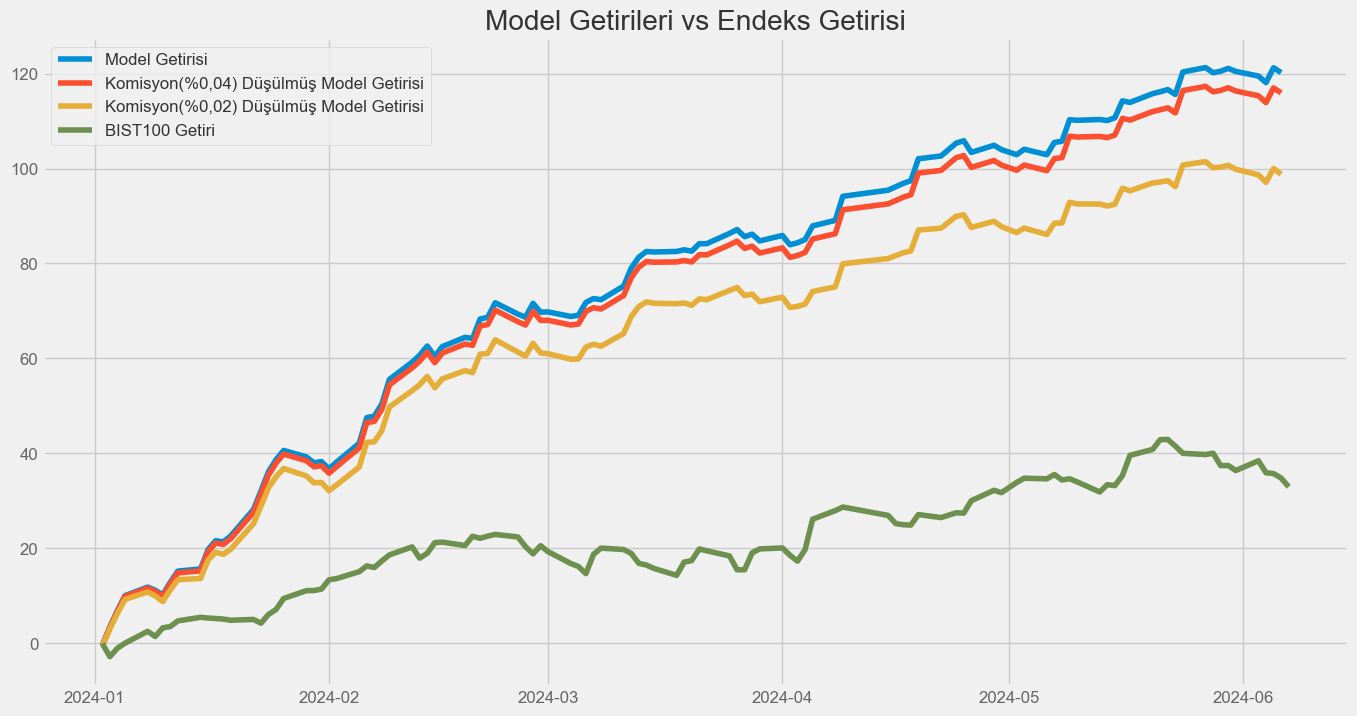

In [112]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.title("Model Getirileri vs Endeks Getirisi")
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Model Getirisi")
plt.plot(top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Komisyon(%0,04) Düşülmüş Model Getirisi")
plt.plot(top_5_rows2.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Komisyon(%0,02) Düşülmüş Model Getirisi")
plt.plot(endeks1["Getiri"],label="BIST100 Getiri")
legend_properties = {'fontweight':'bold'}
plt.legend()

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'CRDFA.IS'),
  Text(0, 1, 'ESCAR.IS'),
  Text(0, 2, 'SAMAT.IS'),
  Text(0, 3, 'RALYH.IS'),
  Text(0, 4, 'MAVI.IS'),
  Text(0, 5, 'EUYO.IS'),
  Text(0, 6, 'MTRKS.IS'),
  Text(0, 7, 'PAPIL.IS'),
  Text(0, 8, 'MPARK.IS'),
  Text(0, 9, 'AVTUR.IS'),
  Text(0, 10, 'OYAYO.IS'),
  Text(0, 11, 'TRILC.IS'),
  Text(0, 12, 'ISGYO.IS'),
  Text(0, 13, 'SKYMD.IS'),
  Text(0, 14, 'SEKUR.IS'),
  Text(0, 15, 'KLRHO.IS'),
  Text(0, 16, 'PINSU.IS'),
  Text(0, 17, 'TSGYO.IS'),
  Text(0, 18, 'METUR.IS'),
  Text(0, 19, 'GRSEL.IS'),
  Text(0, 20, 'LKMNH.IS'),
  Text(0, 21, 'SKYLP.IS'),
  Text(0, 22, 'LRSHO.IS'),
  Text(0, 23, 'ZEDUR.IS'),
  Text(0, 24, 'SELGD.IS'),
  Text(0, 25, 'BAYRK.IS'),
  Text(0, 26, 'BEGYO.IS'),
  Text(0, 27, 'ERSU.IS'),
  Text(0, 28, 'AGROT.IS'),
  Text(0, 29, 'JANTS.IS')])

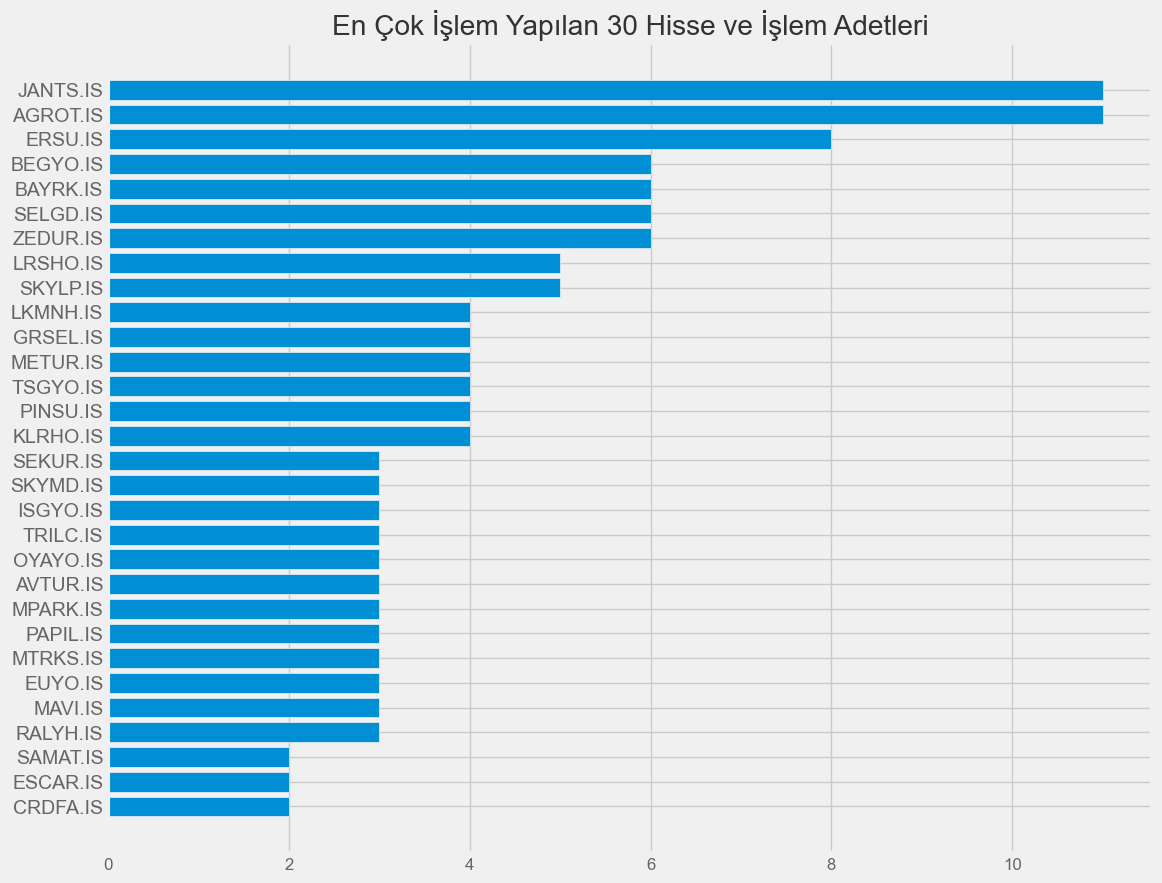

In [113]:
plt.figure(figsize=(12,10))
plt.title("En Çok İşlem Yapılan 30 Hisse ve İşlem Adetleri")
plt.barh(top_5_rows["Hisse"].value_counts().sort_values().tail(30).index,top_5_rows["Hisse"].value_counts().sort_values().tail(30).values)
plt.yticks(fontsize=13,fontweight="bold",font="Arial")

In [117]:

returns=top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-2].dropna()/2
returns=returns/100
returns=pd.DataFrame(returns)
returns["Kar"]=np.where((returns>0),1,0)
returns
returns

,Gerçek,Kar
Date,,
2024-01-02,-0.004369,0
2024-01-03,0.038014,1
2024-01-04,0.034280,1
2024-01-05,0.031085,1
2024-01-08,0.017576,1
...,...,...
2024-05-31,-0.006787,0
2024-06-03,-0.010144,0
2024-06-04,-0.014208,0


In [118]:
def ortalama_kazanma_serisi_uzunlugu(veri):
    kazanma_serileri = []  # Kazanma serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kazanma serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 1:  # Eğer 1 görürsek,
            current_series_length += 1  # Kazanma serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kazanma serisi bitmişse,
                kazanma_serileri.append(current_series_length)  # Kazanma serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kazanma serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kazanma serisi varsa,
        kazanma_serileri.append(current_series_length)  # Son kazanma serisini de listeye ekle.
    
    # Kazanma serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kazanma_serileri) / len(kazanma_serileri)
    
    return ortalama_uzunluk



# Fonksiyonu çağırarak ortalama kazanma serisi uzunluğunu bul
ortalama = ortalama_kazanma_serisi_uzunlugu(list(returns["Kar"].values))
print("Ortalama kazanma serisi uzunluğu:", ortalama)


Ortalama kazanma serisi uzunluğu: 2.8461538461538463


In [119]:
def ortalama_kaybetme_serisi_uzunlugu(veri):
    kaybetme_serileri = []  # Kaybetme serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kaybetme serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 0:  # Eğer 0 görürsek,
            current_series_length += 1  # Kaybetme serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kaybetme serisi bitmişse,
                kaybetme_serileri.append(current_series_length)  # Kaybetme serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kaybetme serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kaybetme serisi varsa,
        kaybetme_serileri.append(current_series_length)  # Son kaybetme serisini de listeye ekle.
    
    # Kaybetme serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kaybetme_serileri) / len(kaybetme_serileri)
    
    return kaybetme_serileri



# Fonksiyonu çağırarak ortalama kaybetme serisi uzunluğunu bul
ortalama = ortalama_kaybetme_serisi_uzunlugu(list(returns["Kar"].values))
print("Ortalama kaybetme serisi uzunluğu:", ortalama)


Ortalama kaybetme serisi uzunluğu: [1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1]


In [120]:
endeks1["Return"]=(endeks1["Adj Close"]/endeks1["Adj Close"].shift(1))-1
endeks1

,Open,High,Low,Close,Adj Close,Volume,Getiri,Return
Date,,,,,,,,
2024-01-02,7542.299805,7634.100098,7542.299805,7624.299805,7624.299805,2397081700,0.000000,NaN
2024-01-03,7624.600098,7624.600098,7411.799805,7412.000000,7412.000000,2169646100,-2.784515,-0.027845
2024-01-04,7421.899902,7547.799805,7387.000000,7547.799805,7547.799805,2391591200,-1.003371,0.018322
2024-01-05,7570.100098,7628.700195,7532.200195,7628.700195,7628.700195,2355101900,0.057715,0.010718
2024-01-08,7667.899902,7824.600098,7667.899902,7818.899902,7818.899902,2873781100,2.552367,0.024932
...,...,...,...,...,...,...,...,...
2024-06-03,10443.200195,10564.900391,10334.799805,10556.799805,10556.799805,2819200600,38.462548,0.015028
2024-06-04,10576.599609,10610.200195,10362.500000,10364.599609,10364.599609,2628421000,35.941659,-0.018206
2024-06-05,10403.200195,10434.700195,10239.599609,10351.000000,10351.000000,2695925200,35.763287,-0.001312


In [125]:
df[df["Hisse"]=="GARAN.IS"]

,High,Low,Open,Adj Close,Volume,Hisse,Tavan Kontrol,RSI,SMA 5,SMA 10,...,Stoch_Oscillator,CCI,ROC,Return,Gerçek Return,Date,Endeks,Endeks Return,Endeks Return Lag,Return Lag
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,6.55,6.35,6.40,6.45,1.378722e+08,GARAN.IS,0,18.826130,7.464,7.464,...,2.430134,-165.112327,-53.362256,3.100775,1.550388,2010-01-06,545.473984,0.798847,1.399527,0.000000
2010-01-07,6.60,6.40,6.45,6.55,1.032084e+08,GARAN.IS,0,19.898606,6.420,6.420,...,3.841229,-130.852301,-51.517395,1.526718,-0.751880,2010-01-07,549.728984,0.780056,0.798847,1.550388
2010-01-08,6.85,6.60,6.65,6.60,2.577438e+08,GARAN.IS,0,20.464438,6.470,6.470,...,4.481434,-105.949431,-49.191686,-3.030303,-3.007519,2010-01-08,547.978984,-0.318339,0.780056,0.763359
2010-01-11,6.70,6.40,6.65,6.45,2.388794e+08,GARAN.IS,0,20.007820,6.500,6.500,...,2.717391,-94.294879,-49.805447,-1.550388,0.781250,2010-01-11,539.211016,-1.600056,-0.318339,-2.272727
2010-01-12,6.50,6.35,6.40,6.45,1.103711e+08,GARAN.IS,0,20.007820,6.500,6.500,...,2.824859,-84.074904,-49.805447,0.775194,1.574803,2010-01-12,536.763984,-0.453817,-1.600056,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,106.40,103.10,104.70,104.60,1.636146e+09,GARAN.IS,0,69.045545,105.580,105.580,...,71.621622,81.244401,9.128847,-1.242830,-2.283539,2024-06-05,10351.000000,-0.131212,-1.820629,0.287632
2024-06-06,106.50,102.70,105.10,102.70,1.238406e+09,GARAN.IS,0,64.326819,105.600,105.600,...,51.044776,68.508715,1.382034,-2.677702,-3.242982,2024-06-06,10279.700195,-0.688820,-0.131212,-1.816444
2024-06-07,104.00,99.15,103.30,99.95,1.157865e+09,GARAN.IS,0,58.134069,104.030,104.030,...,25.255973,30.053753,-0.744786,2.751376,-1.500750,2024-06-07,10139.000000,-1.368719,-0.688820,-2.677702


In [121]:
endeks1["Kar"]=np.where((endeks1["Return"]>0),1,0)


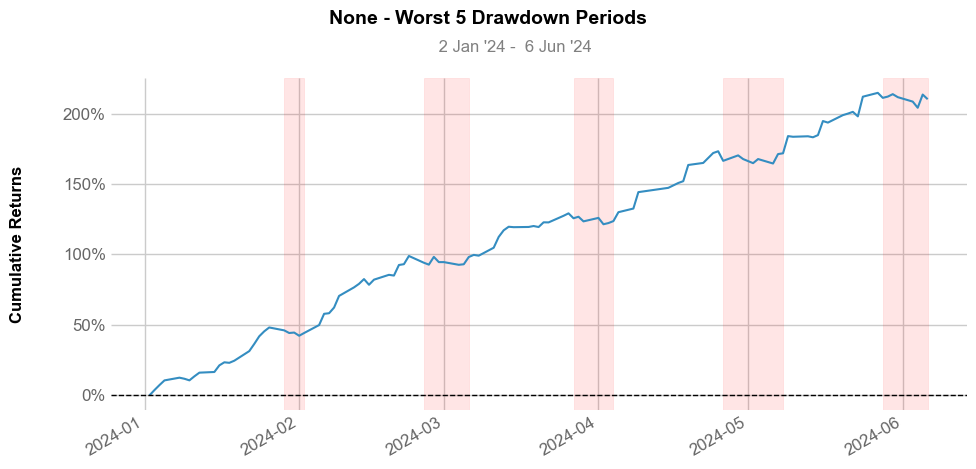

In [128]:
qs.plots.drawdowns_periods(returns=returns["Gerçek"])

In [129]:
qs.reports.html(returns=returns["Gerçek"],benchmark=endeks1["Return"])

In [130]:
returns["Gerçek"].std()*100

1.9394836124488095

In [131]:
qs.reports.metrics(returns=returns["Gerçek"],benchmark=endeks1["Return"])

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2024-01-02   2024-01-02
End Period          2024-06-06   2024-06-06
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       100.0%

Cumulative Return   34.83%       212.01%
CAGR﹪              62.05%       528.47%

Sharpe              3.34         8.91
Prob. Sharpe Ratio  98.9%        100.0%
Sortino             6.15         25.44
Sortino/√2          4.35         17.99
Omega               4.48         4.48

Max Drawdown        -7.0%        -3.99%
Longest DD Days     39           13

Gain/Pain Ratio     0.73         3.48
Gain/Pain (1M)      21.64        287.91

Payoff Ratio        1.57         2.4
Profit Factor       1.73         4.48
Common Sense Ratio  2.26         13.12
CPC Index           1.46         7.51
Tail Ratio          1.3          2.93
Outlier Win Ratio   3.51         2.22
Outlier Loss Ratio  2.82         2.32

MTD                 -1.16%       -0.47%
3M     

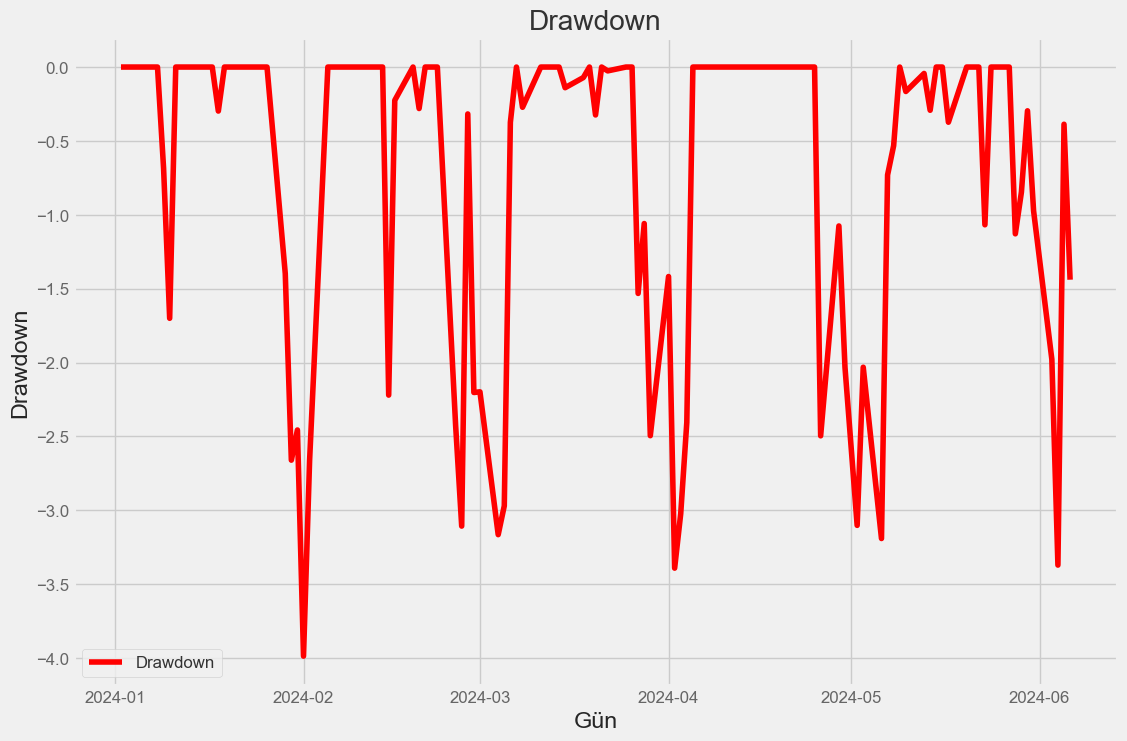

In [132]:
import pandas as pd
import matplotlib.pyplot as plt


# Convert to DataFrame
cumulative_returns = np.cumprod(1+returns["Gerçek"])


def calculate_drawdowns(returns):
    peak = returns[0]
    drawdowns = [0]  # İlk değer 0, çünkü başlangıçta herhangi bir drawdown yok

    for ret in returns[1:]:
        if ret > peak:
            peak = ret
            drawdowns.append(0)  # Yeni zirve bulunduğunda drawdown sıfırlanır
        else:
            drawdowns.append(-100*((peak - ret) / peak))  # Drawdown hesaplanır
    
    return drawdowns

# Drawdown'ları hesapla
drawdowns = calculate_drawdowns(cumulative_returns)


# Grafik çizimi
plt.figure(figsize=(12, 8))
plt.plot(returns.index, drawdowns, label='Drawdown', color='red', linestyle='-')
plt.xlabel('Gün')
plt.ylabel('Drawdown')
plt.title('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
feature_importance = model.get_feature_importance(type='FeatureImportance')

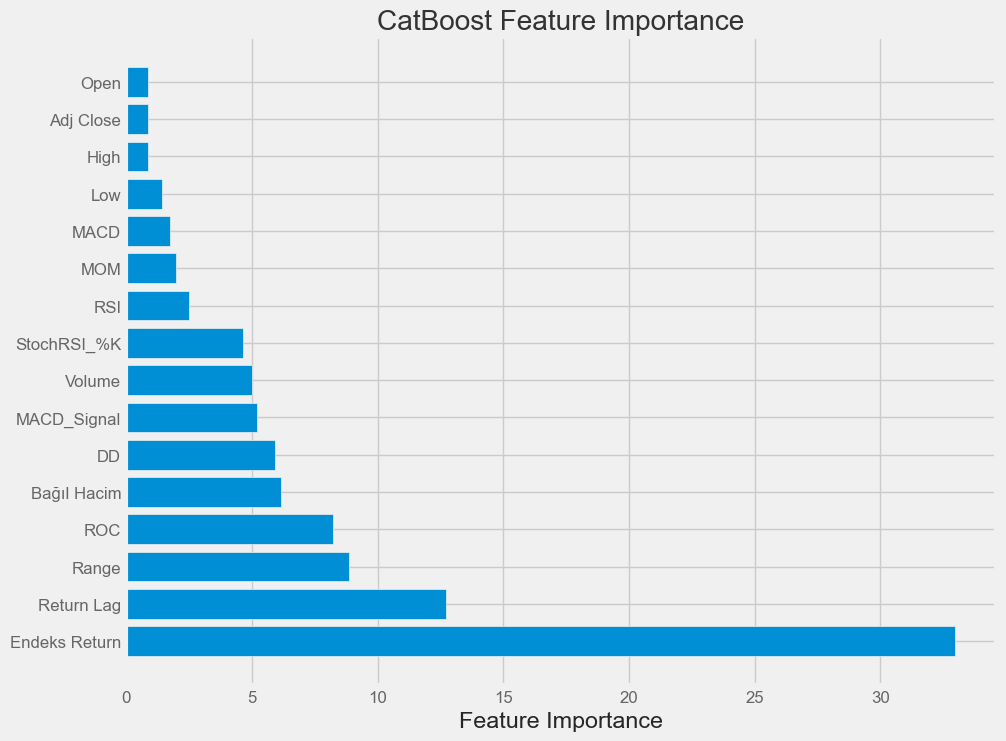

In [134]:
import catboost
feature_importance = model.get_feature_importance(type='FeatureImportance')
# Özellik isimlerini alın
feature_names = model.feature_names_

# Özellik önemlerini bir sözlükte saklayın
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Özellik önemlerine göre sıralayın
sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Görselleştirme
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.yticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

In [137]:
top_5_rows1["date"]=pd.to_datetime(top_5_rows1.index)

In [139]:
satışlar = []
indexler = top_5_rows1['date'].unique()

for date in top_5_rows1['date']:
    future_dates = indexler[indexler > date]
    if len(future_dates) >= 2:
        satış_tarihi = future_dates[1]
    else:
        satış_tarihi = pd.NaT
    satışlar.append(satış_tarihi)

top_5_rows1['satış_tarihi'] = satışlar

In [140]:
df["date"]=pd.to_datetime(df.index)

In [141]:
top_5_rows1['Alış Fiyatı'] = top_5_rows1.set_index(['date', 'Hisse']).index.map(df.set_index(['date', 'Hisse'])['Adj Close'])
top_5_rows1['Satış Fiyatı'] = top_5_rows1.set_index(['satış_tarihi', 'Hisse']).index.map(df.set_index(['date', 'Hisse'])['Open'])

top_5_rows1

,Gerçek,Tahmin,Hisse,Tavan,date,satış_tarihi,Alış Fiyatı,Satış Fiyatı
Date,,,,,,,,
2024-01-02,-1.102644,3.762455,SANEL.IS,0,2024-01-02,2024-01-04,27.38,27.10
2024-01-02,2.269446,3.380081,MTRKS.IS,0,2024-01-02,2024-01-04,37.03,37.90
2024-01-02,-3.788134,2.506032,HUBVC.IS,0,2024-01-02,2024-01-04,8.36,8.05
2024-01-03,7.467170,2.567847,DOGUB.IS,0,2024-01-03,2024-01-05,15.90,17.10
2024-01-03,2.840723,1.872810,OSTIM.IS,0,2024-01-03,2024-01-05,7.19,7.40
...,...,...,...,...,...,...,...,...
2024-06-10,-99.540363,0.840057,KCHOL.IS,0,2024-06-10,NaT,209.40,NaN
2024-06-10,-99.775277,0.813556,GARAN.IS,0,2024-06-10,NaT,98.45,NaN
2024-06-12,-99.740436,2.488069,MPARK.IS,0,2024-06-12,NaT,321.00,NaN


In [142]:
top_5_rows1=top_5_rows1.rename(columns={"date":"Alış Tarihi","Gerçek":"Kar","satış_tarihi":"Satış Tarihi"})
top_5_rows1

,Kar,Tahmin,Hisse,Tavan,Alış Tarihi,Satış Tarihi,Alış Fiyatı,Satış Fiyatı
Date,,,,,,,,
2024-01-02,-1.102644,3.762455,SANEL.IS,0,2024-01-02,2024-01-04,27.38,27.10
2024-01-02,2.269446,3.380081,MTRKS.IS,0,2024-01-02,2024-01-04,37.03,37.90
2024-01-02,-3.788134,2.506032,HUBVC.IS,0,2024-01-02,2024-01-04,8.36,8.05
2024-01-03,7.467170,2.567847,DOGUB.IS,0,2024-01-03,2024-01-05,15.90,17.10
2024-01-03,2.840723,1.872810,OSTIM.IS,0,2024-01-03,2024-01-05,7.19,7.40
...,...,...,...,...,...,...,...,...
2024-06-10,-99.540363,0.840057,KCHOL.IS,0,2024-06-10,NaT,209.40,NaN
2024-06-10,-99.775277,0.813556,GARAN.IS,0,2024-06-10,NaT,98.45,NaN
2024-06-12,-99.740436,2.488069,MPARK.IS,0,2024-06-12,NaT,321.00,NaN


In [147]:
top_5_rows1[["Alış Tarihi","Satış Tarihi","Hisse","Alış Fiyatı","Satış Fiyatı","Kar"]].to_excel("C:/Users/Bora/Documents/Github/streamlit_trading/veri.xlsx")

In [148]:
top_5_rows1=pd.read_excel("veri.xlsx")
top_5_rows1

,Unnamed: 0,Alış Tarihi,Satış Tarihi,Hisse,Alış Fiyatı,Satış Fiyatı,Ağırlık,Ağırlıklı Getiri,Kar
0,0,2024-01-02,2024-01-04,ANSGR.IS,63.5,64.75,0.348911,0.658921,1.888504
1,1,2024-01-02,2024-01-04,TURSG.IS,42.2,43.40,0.502618,0.793517,1.578768
2,2,2024-01-02,2024-01-04,AKCNS.IS,148.9,145.50,0.148471,-0.410725,-2.766367
3,3,2024-01-03,2024-01-05,YEOTK.IS,178.8,185.00,0.023224,0.065685,2.828277
4,4,2024-01-03,2024-01-05,ANSGR.IS,64.8,66.10,0.425583,-0.099723,-0.234321
...,...,...,...,...,...,...,...,...,...
311,311,2024-06-04,2024-06-06,TURSG.IS,81.1,81.00,0.181157,0.164207,0.906436
312,312,2024-06-04,2024-06-06,KRDMD.IS,30.8,30.34,0.427287,0.465244,1.088831
313,313,2024-06-05,NaT,ANSGR.IS,117.3,NaN,0.173299,-12.992801,-74.973436
314,314,2024-06-05,NaT,TTKOM.IS,49.5,NaN,0.610076,-55.103538,-90.322424


In [267]:
alımlar=['2024-02-09', '2024-03-07', '2024-03-11','2024-03-21', 
               '2024-04-03', '2024-04-08', '2024-06-05']
satışlar=['2024-02-14', '2024-03-11','2024-03-15', '2024-03-25',
               '2024-04-05', '2024-04-16', '2024-06-07']

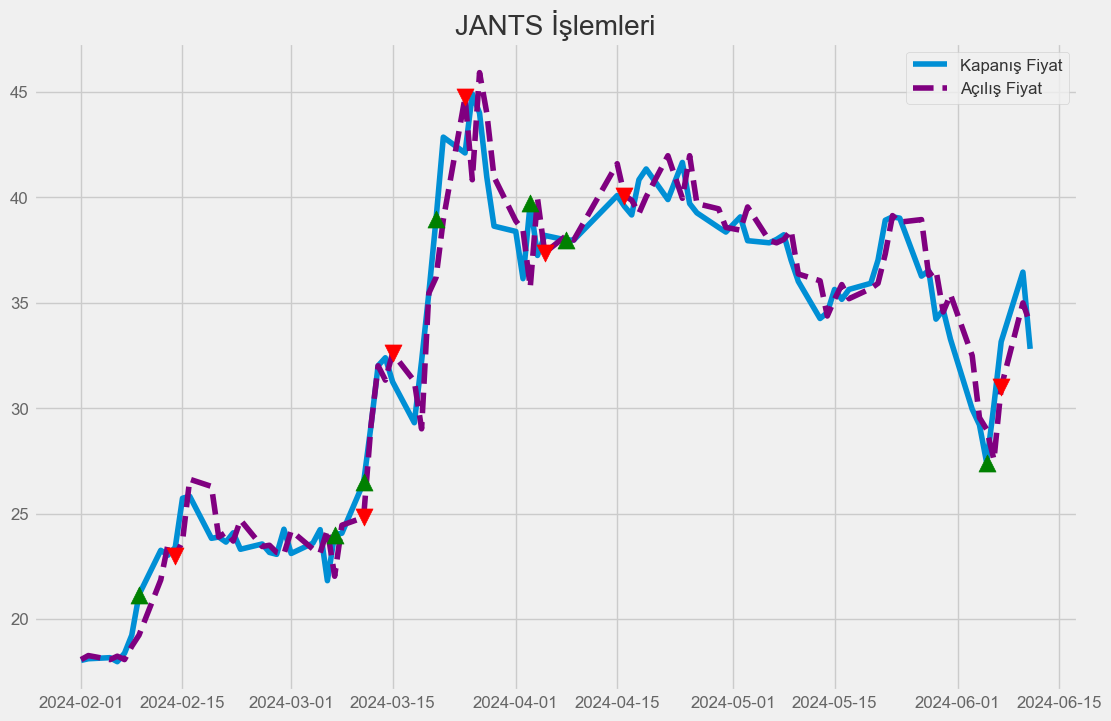

In [269]:
plt.figure(figsize=(12,8))
plt.title("JANTS İşlemleri")
plt.plot(df[df["Hisse"]=="JANTS.IS"]["Adj Close"].loc["2024-02-01":],label="Kapanış Fiyat")
plt.plot(df[df["Hisse"]=="JANTS.IS"]["Open"].loc["2024-02-01":],"--",color="purple",label="Açılış Fiyat")
for alım in alımlar:
   plt.scatter(x=alım,y=df[df["Hisse"]=="JANTS.IS"].loc[alım]["Adj Close"],marker="^",s=150,color="green",zorder=3)
for satış in satışlar:
   plt.scatter(x=satış,y=df[df["Hisse"]=="JANTS.IS"].loc[satış]["Open"],marker="v",s=150,color="red",zorder=4)
plt.legend()